# Introdução

O objetivo deste projeto é construir um modelo para classificar as resenhas dos usuários, com desempenho score F1 ≥ 0.85.

A métrica F1 foi escolhida por uma medida recomendada de desempenho em problemas de classificação binária, quanto maior for, melhor será o desempenho do modelo tanto para classificar positiva, ou negativamente.

__Dicionário de dados:__
* 'review' — texto da resenha
* 'ds_part_train/test' — respectivos registros de treino e teste
* 'pos' — classificação (0 negativa, 1 positiva)

In [1]:
import pandas as pd
import math
import nltk
import time
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

## 1. Data overview

In [2]:
reviews = pd.read_csv('datasets/movie_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [3]:
reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [5]:
reviews.duplicated().sum()

0

In [6]:
reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Constatações:
* 47331 resenhas
* 2 valores faltantes em average_rating e votes

## 2. Pre-processing

O único pre-processamento será eliminar os valores faltantes, por serem ínfimos comparado ao tamanho do conjunto de dados.

In [7]:
# eliminating missing values
reviews.dropna(inplace=True)

## 3. EDA

Como o objetivo é apenas analisar o sentimento baseado nas to texto das resenhas, a seguir será verificado se há desequilíbrio na quantidade de resenhas.

##### Class balance check

In [8]:
labels = reviews['pos'].value_counts()
labels

0    23715
1    23614
Name: pos, dtype: int64

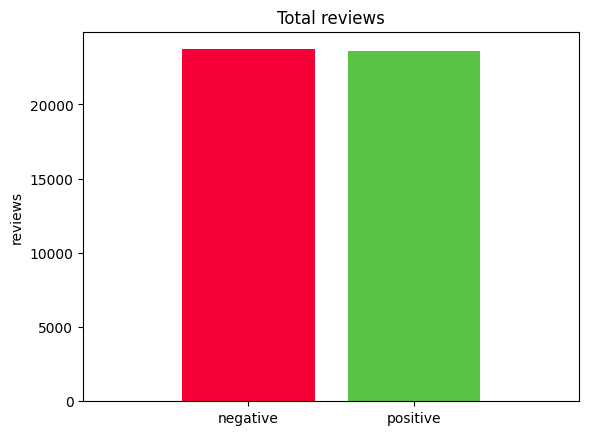

In [9]:
plt.bar([0,1], labels, color=['#F40036', '#5AC344'])
plt.xlim(-1,2)
plt.xticks([0,1], ['negative','positive'])
plt.ylabel('reviews')
plt.title('Total reviews')
plt.show()

A quantidade de resenhas está bem equilibrada 23715 (negativas) e 23614 (positivas). A seguir os dados serão preparados para a etapa de teste de modelos e seleção do melhor.

## 4. Data preparation

In [10]:
# function to prepare texts to ML training
def text_preprocess(text):
    text = text.lower() # minúsculas
    words = nltk.word_tokenize(text, language='english') # Tokenização (separação em palavras)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords e aplica lematização
    return " ".join(words)

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
reviews['review_preprocessed'] = reviews['review'].apply(text_preprocess)

In [13]:
train = reviews.query('ds_part == "train"').copy()
test = reviews.query('ds_part == "test"').copy()

X_train = train['review_preprocessed']
y_train = train['pos']

X_test = test['review_preprocessed']
y_test = test['pos']

In [14]:
vectorizer = CountVectorizer()

In [15]:
# transform texts into vectors
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## 5. Modeling

A seguir os 3 modelos serão treinados e testados, visando escolher o que entrega melhor F1-score no conjunto de treinamento. Todos modelos são modelos usados para classificação, sendo o primeiro o mais simples que geralmente costuma além de ser rápido entregar bons scores.

In [16]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'CatBoost Classifier': CatBoostClassifier(verbose=False, random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42)
}

In [17]:
params = {
    'Logistic Regression': {'C': [0.01, 0.1, 1.0]},
    'CatBoost Classifier': {'learning_rate': [0.1, 0.2], 'n_estimators': [7, 21]},
    'Random Forest Classifier': {'n_estimators': [10, 21, 100], 'max_depth': [7, 21]}
}

In [18]:
res = {'Model':[],
       'F1-Score':[],
       'duration':[],
       'best_params':[]}

for model_name, model in models.items():
    start_time = time.time()
    grid_search = GridSearchCV(model, params[model_name], scoring=make_scorer(f1_score), n_jobs=1, cv=3)
    grid_search.fit(X_train_vectorized, y_train)
    
    # print("Top Parâmetros:", grid_search.best_params_)

    end_time = time.time()
    
    res['Model'].append(model_name)
    res['F1-Score'].append(grid_search.best_score_)
    res['duration'].append(f'{(end_time - start_time):.0f}s')
    res['best_params'].append(grid_search.best_params_)

res = pd.DataFrame(res)
eval = res.drop(columns='best_params').sort_values(by='F1-Score',ascending=False)
eval

,Model,F1-Score,duration
0,Logistic Regression,0.864582,29s
2,Random Forest Classifier,0.842257,144s
1,CatBoost Classifier,0.812540,155s


O modelo com maior desempenho durante o treinamento foi o Logistic Regression (F1-Score > 0.85)
* ajuste rápido aos dados (apenas 29s)
* f1-score acima do requisitado (0.86) > 0.85

## 6. Final Test

Para atestar a eficácia do modelo, o modelo com os hiperparâmetros encontrados será aplicado a dados novos.

In [19]:
res.query(f'Model == "{eval.values[0][0]}"')

,Model,F1-Score,duration,best_params
0,Logistic Regression,0.864582,29s,{'C': 0.01}


In [20]:
# Logistic Regression
best_logreg_model = LogisticRegression(C=0.01, max_iter=100, random_state=42)
best_logreg_model.fit(X_train_vectorized, y_train)

LogisticRegression(C=0.01, random_state=42)

In [21]:
# Handmade reviews, 5 positive e 5 negative
my_reviews = pd.DataFrame([
    "This movie is absolutely fantastic! The plot is engaging, and the characters are well-developed.",
    "I loved this movie. The acting is superb, and the story is touching.",
    "The cinematography and special effects are amazing. I highly recommend this movie.",
    "This film is a masterpiece. The direction, performances, and music are outstanding.",
    "A must-watch movie! It kept me at the edge of my seat from start to finish.",
    "I was very disappointed with this movie. The plot was confusing, and the acting was terrible.",
    "This film was a waste of time. The story was dull, and the characters were uninteresting.",
    "The movie had poor direction, and the acting felt forced and artificial.",
    "My experience with this film was unpleasant. The pacing was slow, and the story was predictable.",
    "The movie lacked substance and failed to deliver a compelling narrative."
], columns=['review'])

# preprocess texts
my_reviews['review'] = my_reviews['review'].apply(text_preprocess)

# vectorize-it
my_reviews_vectorized = vectorizer.transform(my_reviews['review'])

# make predictions
logreg_predictions = best_logreg_model.predict(my_reviews_vectorized)

# print results
print('\nExpected classification:', '[1 1 1 1 1 0 0 0 0 0]')
print()
print('Predicted:', logreg_predictions)


Expected classification: [1 1 1 1 1 0 0 0 0 0]

Predicted: [1 1 1 1 1 0 0 0 0 0]


## Conclusões
#### Visão geral
Os textos foram carregados e ao analisar o resumo os dados foram encontrados valores faltantes, posteriomente tratados (removidos). A quantidade de exemplos de análises positivas e negativas foi bem equilibrada o que evita que o modelo dê maior preferência para uma das classes.

#### Transformações realizadas
Para possibilitar o treinamento dos modelos os textos foram transformados, eliminando stopwords, colocando todas as palavras em minusculas além de remover espaços adicionais.

#### Treino de Modelos e ajuste de hiperparâmetros
Uma vez preparados os textos foram vetorizados e os modelos foram testados com diferentes parâmetros a fim de selecionar aquele com melhor desempenho, ou seja, (F1 ≥ 0,85).

#### Modelo escolhido
Dentre os 3 modelos treinados o que teve o melhor desempenho foi o Logistic Regression (F1 = 0,86), o que indica que o modelo é bom tanto para classificar comentários positivos quanto negativos.
* Logistic Regression (C=0.01)

#### Teste final
Por último foi realizado um teste em resenhas escritas por mim (5 positivas e 5 negativas), para verificar a consistência dos resultados com o desempenho do modelo durante a fase de testes, que alcançou acerto de 100%.

#### Ajustes futuros
Novos ajustes podem ser realizados para alçar resultados ainda melhores, como novas rodadas de seleção de hiperparametros ou uso de bigram.